In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 500

In [2]:
G20_and_EU = ["Saudi Arabia", "Argentina", "Australia", "Brazil", "Canada", "China", "South Korea",
              "Republic of Korea", "France", "Germany", "Japan", "India", "Indonesia", "Italy",
              "Mexico", "United Kingdom", "The United Kingdom", "Russia", "Russian Federation",
              "United States", "United States of America", "South Africa", "Turkey", "Türkiye",
              "Austria", "Belgium", "Bulgaria", "Cyprus", "Croatia", "Denmark", "Estonia", "Finland",
              "Greece", "Ireland", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
              "Poland", "Portugal", "Czech Republic", "Czechia", "Romania", "Slovak Republic",
              "Slovakia", "Slovenia", "Spain", "Sweden", "Hungary"]

### Time series

In [3]:
amzn = pd.read_csv("AMZN_weekly.csv")[["Date", "Adj Close"]]
zoom = pd.read_csv("ZM_weekly.csv")[["Date", "Adj Close"]]

zoom["Date"] = pd.to_datetime(zoom["Date"], format = "%Y/%m/%d")
amzn["Date"] = pd.to_datetime(amzn["Date"], format = "%Y/%m/%d")

start_date = amzn["Date"].min() # from ZOOM
end_date = amzn["Date"].max()

In [4]:
def week_aggregator(data, date_col, target_col, aggfunc = "sum"):
    out = []
    indexes = []
    date_list = amzn["Date"].tolist()
    
    if aggfunc not in ["sum", "mean"]:
        raise "Only 'sum' and 'mean' supported for 'aggfunc'"
    
    for n in range(len(date_list)):
        
        if n == 0:
            d_0 = date_list[n] - datetime.timedelta(days = 7)
            d_1 = date_list[n]
        else:
            d_0 = date_list[n-1]
            d_1 = date_list[n]    
        
        if aggfunc == "sum":
            aggregate = data.loc[(data[date_col] > d_0) &
                                 (data[date_col] <= d_1), target_col].sum()
        else: # mean
            aggregate = data.loc[(data[date_col] > d_0) &
                                 (data[date_col] <= d_1), target_col].mean()
            
        out += [aggregate]
        indexes += [d_1]
        
    out = pd.Series(out, index = indexes).fillna(0)
    out = out.reset_index().rename(columns = {"index": "Date",
                                              0: target_col})
    return out

### Daily cases

In [5]:
df_cases = pd.read_csv("WHO-COVID-19-global-data.csv")
df_cases["Date_reported"] = pd.to_datetime(df_cases["Date_reported"], format = "%Y/%m/%d")
# Keep only G20+Europe
df_cases = df_cases[df_cases["Country"].isin(G20_and_EU)]

# Set time interval according to the stocks data
df_cases = df_cases[(df_cases["Date_reported"] <= end_date) &
                    (df_cases["Date_reported"] >= start_date)]

In [6]:
# Aggregate by week
df_cases = week_aggregator(data = df_cases, date_col = "Date_reported",
                           target_col = "New_cases", aggfunc = "sum")

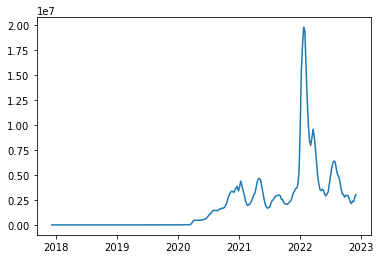

In [7]:
plt.plot(df_cases["Date"], df_cases["New_cases"]);

### Restriction index

In [8]:
oxf_restr = pd.read_csv("OxCGRT_nat_latest.csv")

oxf_restr = oxf_restr.drop(["Jurisdiction", "RegionName", "RegionCode", "M1_Wildcard"] +
                           [c for c in oxf_restr.columns
                            if c[0] == "E" and c[1] != "c"] +\
                           [c for c in oxf_restr.columns if c[0] == "V"], axis = 1)

oxf_restr = oxf_restr[oxf_restr["CountryName"].isin(G20_and_EU)]
oxf_restr["Date"] = oxf_restr["Date"].apply(lambda v:
                                            "/".join([str(v)[:4], str(v)[4:6],
                                                      str(v)[6:]]))
oxf_restr["Date"] = pd.to_datetime(oxf_restr["Date"], format = "%Y/%m/%d")

# Set time interval according to the stocks data
oxf_restr = oxf_restr[(oxf_restr["Date"] <= end_date) &
                      (oxf_restr["Date"] >= start_date)]

In [9]:
# Aggregate by week
oxf_restr = week_aggregator(data = oxf_restr, date_col = "Date", aggfunc = "mean",
                            target_col = "StringencyIndex_Average_ForDisplay")

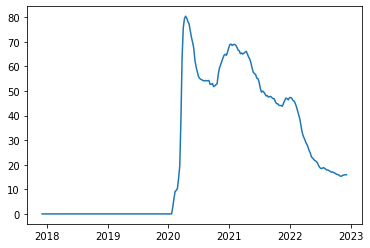

In [10]:
plt.plot(oxf_restr["Date"], oxf_restr["StringencyIndex_Average_ForDisplay"]);

In [11]:
# Put both together
df = df_cases.merge(oxf_restr, on = "Date", how = "inner")
df.to_csv("Contagi_and_restrictions.csv", index = False)

---
---
---